In [3]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [4]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [5]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [84]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18.3
qBase = np.array([[23,20], [23-(np.sqrt(2)*l/2), 20-(np.sqrt(2)*l/2)], [27,20], [27+(np.sqrt(2)*(l)/2), 20-(np.sqrt(2)*(l)/2)],
                  [25, 20+2*np.sqrt(2)], [25,20+2*np.sqrt(2) + l]])


sub_regions = [[28,4,25,0],
               [46,22, 25, 0],
               [33, 17, 47, 17]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.2/beta, 0.3/beta, 0.1/beta]

In [62]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


In [63]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 600 samples from Channel 3
Completed PredictedChannel 3
Drawing 600 samples from Channel 4
Completed PredictedChannel 4
Drawing 480 samples from Channel 5
Completed PredictedChannel 5
Drawing 480 samples from Channel 6
Completed PredictedChannel 6
[0.5714285714285714, 0.8046153846153846, 0.5295508274231678]


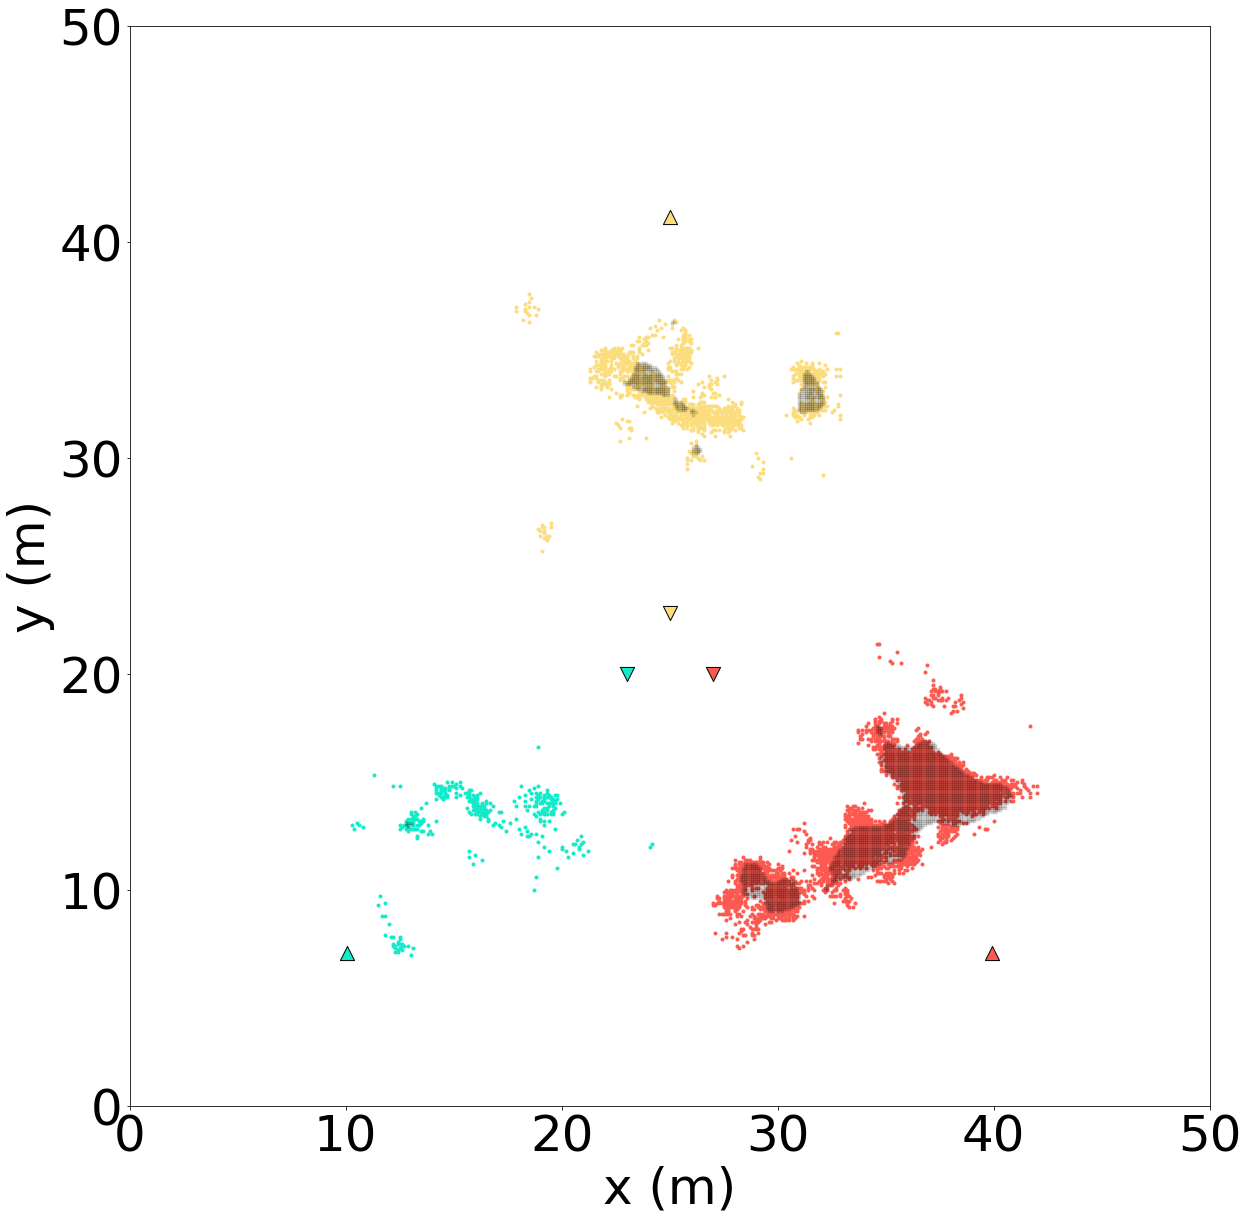

In [64]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [74]:
goodpcs[:2] = pcs[:2]
goodpfs[:2] = pfs[:2]
goodpjcps[0] = pjcps[0]
goodprob_pred_con[0] = prob_pred_con[0]
goodccs[:2] = ccs[:2]
goodcfs[:2] = cfs[:2]
goodtrue_joint_con_fields[0] = true_joint_con_fields[0]
goodtjcps[0] = tjcps[0]


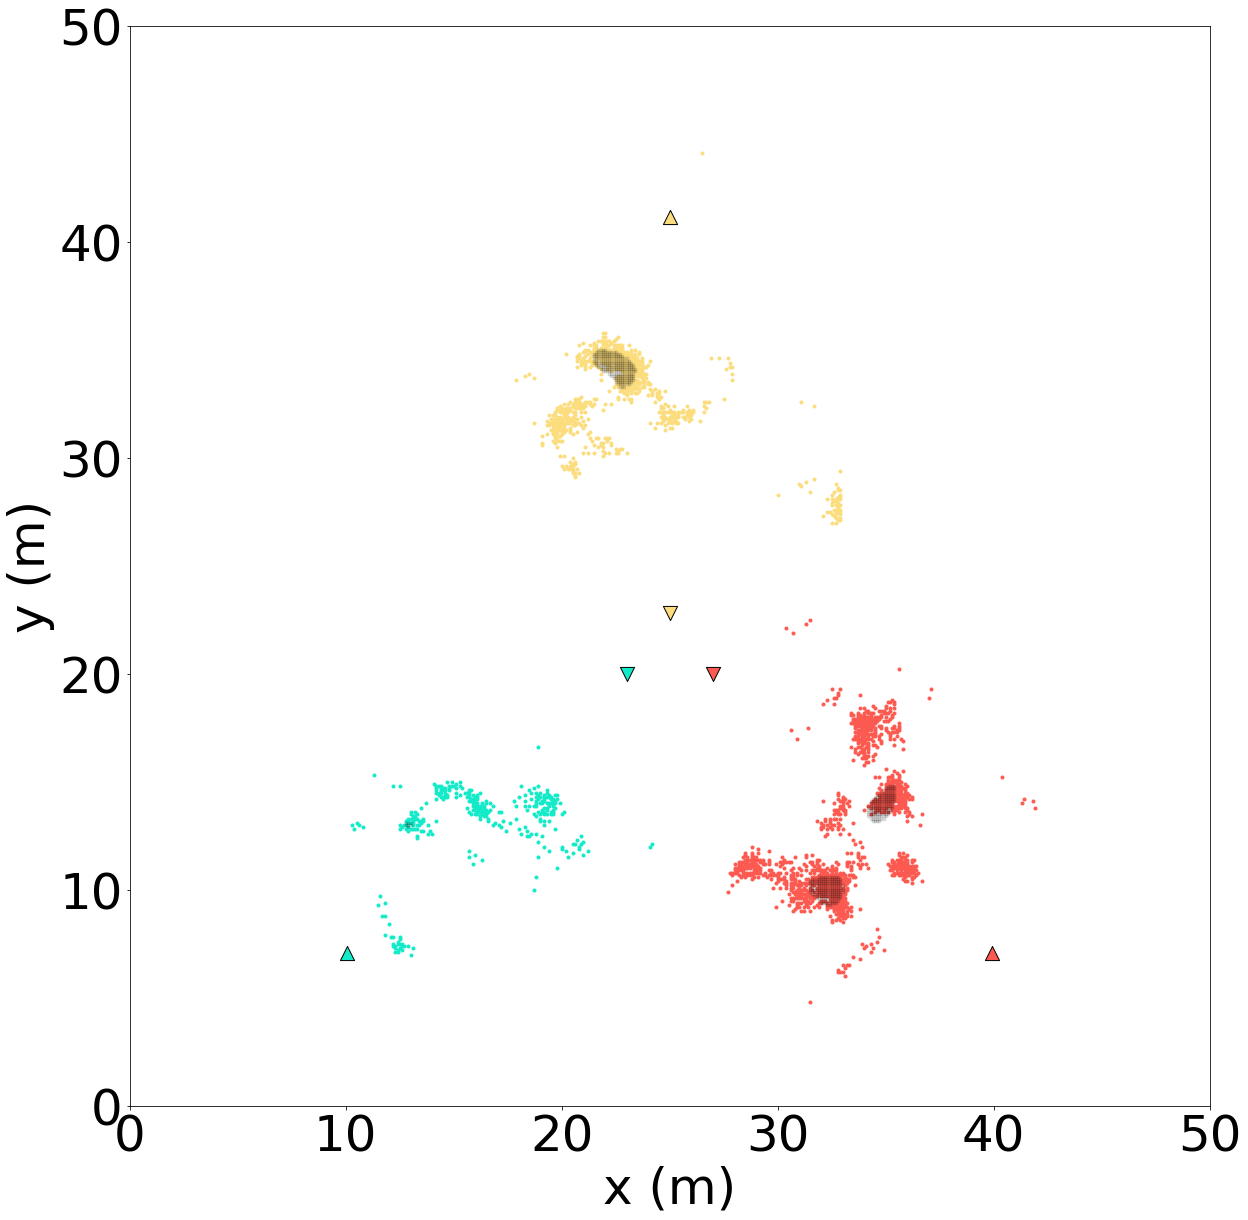

In [75]:
reload(sim)
sim.plotCFwithOverlay(n, goodtjcps, goodpjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [76]:
pcs = goodpcs
pfs = goodpfs
pjcps = goodpjcps
prob_pred_con = goodprob_pred_con
ccs = goodccs
cfs = goodcfs
true_joint_con_fields = goodtrue_joint_con_fields
tjcps = goodtjcps

In [90]:
import CoordTransforms as CT
def change_res(pts, region, res):
    grid = CT.toGridFromRaw(region, res, pts)
    new_raw = CT.toRawFromGrid(region, res, grid)
    return np.unique(new_raw, axis = 0)
    

def brute_force(dt_sys, pcs, v):
    argmin = None
    w_min = float('inf')
    ps = dt_sys.ps
    all_points = dt_sys.Xis
    r0_pts = change_res(all_points[0]['points'], pcs[0].region, 10)
    r1_pts = change_res(all_points[1]['points'], pcs[2].region, 10)
    r2_pts = change_res(all_points[2]['points'], pcs[4].region, 10)
    z = sum([k for k in range(98)])
    print("Total iterations: %d"%(z*len(r0_pts)*len(r1_pts)*len(r2_pts)))
    count = 0
    for pt0 in r0_pts:
        for pt1 in r1_pts:
            for pt2 in r2_pts:
                X = np.array([pt0, pt1, pt2])
                S = dtr.XtoS(X, v)
                for pi_0 in np.arange(0.01,1, 0.01):
                    for pi_1 in np.arange(0.01,1-pi_0, 0.01):
                            pi_2 = 1 - pi_0 - pi_1
                            pi = np.array([pi_0, pi_1, pi_2])
                            w = ps._calc_avg_wait_random(pi, S)
                            if w < w_min:
                                argmin = (pi, X)
                                w_min = w
                            count += 1
                            if count %50000 == 0:
                                print(count)
    return w_min, argmin

In [85]:
dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
1 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
5 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
3 total subregions


In [91]:
v = 1
brute_force(dt_sys, pcs, v)
# 236476800

Total iterations: 2389922472


/home/win/dev/CommMotionPlanning/python/touring_relay/../polling_systems/PollingSystem.py:228: RuntimeWarning: divide by zero encountered in true_divide
  term3 = (np.transpose(pi) @ sk)/(1-self.RhoSys()) * ( (rhok - rhok**2) @ (1/pi) )


KeyboardInterrupt: 

In [89]:
reload(sim)
AORP = sim.calc_AORP(dt_sys, v)
P_tilde, pi_tilde = sim.pi_to_P(AORP['pi'])
print(AORP)
print(P_tilde)
print(pi_tilde)


Optimized Waiting Time: 74.5305
Optimized Waiting Time: 74.5247
{'WT': 74.52467754315505, 'X': array([[13. , 13. ],
       [31.5, 10.4],
       [22.7, 33.3]]), 'pi': array([0.35920635, 0.45362783, 0.18716582])}
[[0.         0.70791562 0.29208438]
 [0.65743896 0.         0.34256104]
 [0.44191836 0.55808164 0.        ]]
[0.36526689 0.39331125 0.24142186]


In [31]:
if False:
    %store dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

Stored 'dt_sys' (DTR)
Stored 'AORP' (dict)
Stored 'TSPNP' (dict)
Stored 'tjcps' (list)
Stored 'pjcps' (list)
Stored 'qBase' (ndarray)
Stored 'region' (list)
Stored 'pcs' (list)
Stored 'pfs' (list)
Stored 'pjcps' (list)
Stored 'prob_pred_con' (list)
Stored 'ccs' (list)
Stored 'cfs' (list)
Stored 'true_joint_con_fields' (list)
Stored 'tjcps' (list)
